**Let’s begin by taking a look at the data.**

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

np.set_printoptions(precision=4, suppress=True)

train_df = pd.read_csv('train.csv')

print(train_df.head())
print(train_df.columns)

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

**There are many missing values (NaNs) and too many columns for straightforward 3D visualization.**

**Let us plot a chart to identify which columns can be safely removed.**

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


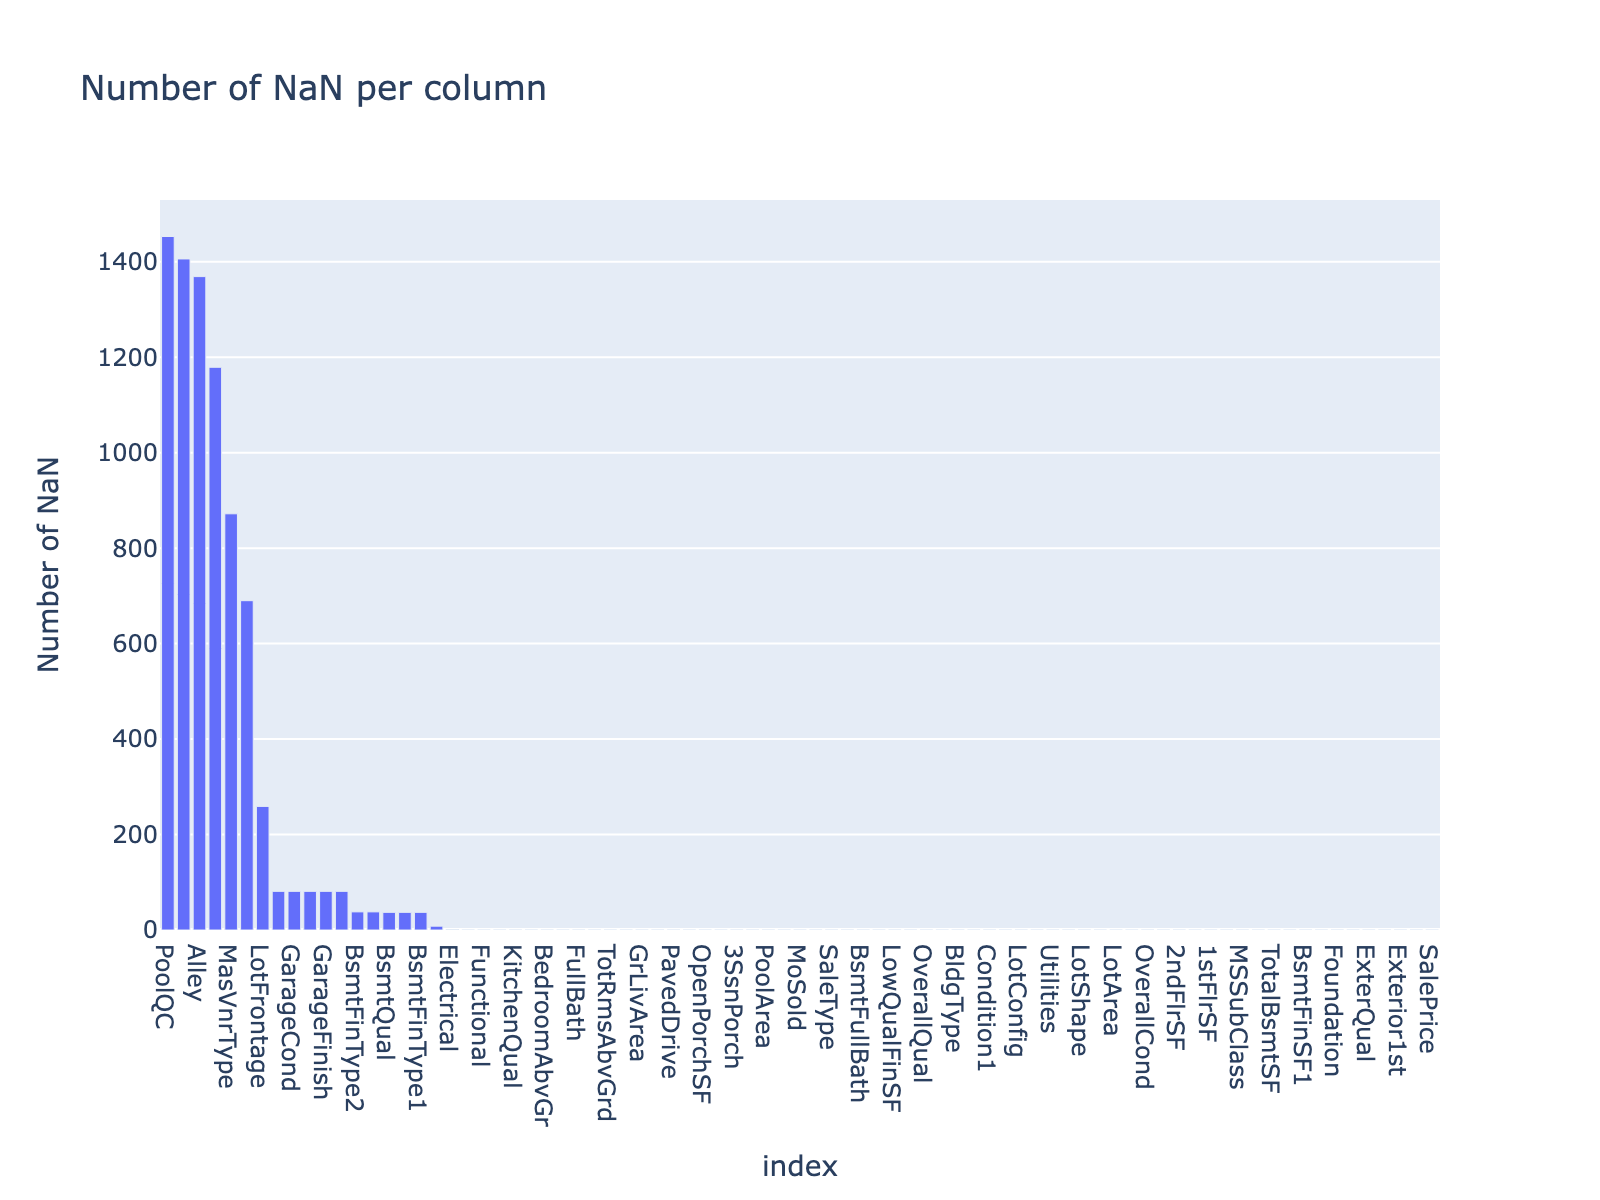

In [30]:
print(train_df.isna().sum())
nans_df = train_df.isna().sum().sort_values(ascending=False)
fig = px.bar(
    nans_df, 
    x=nans_df.index,
    y=nans_df.values,
    labels={"x": "Columns", "y": "Number of NaN"},
    title="Number of NaN per column"
)
fig.update_layout(width=1000, height=800)
fig.show(renderer="png", width=800, height=600, scale=2)

**To better inspect the details, we zoom in on the visualization:**

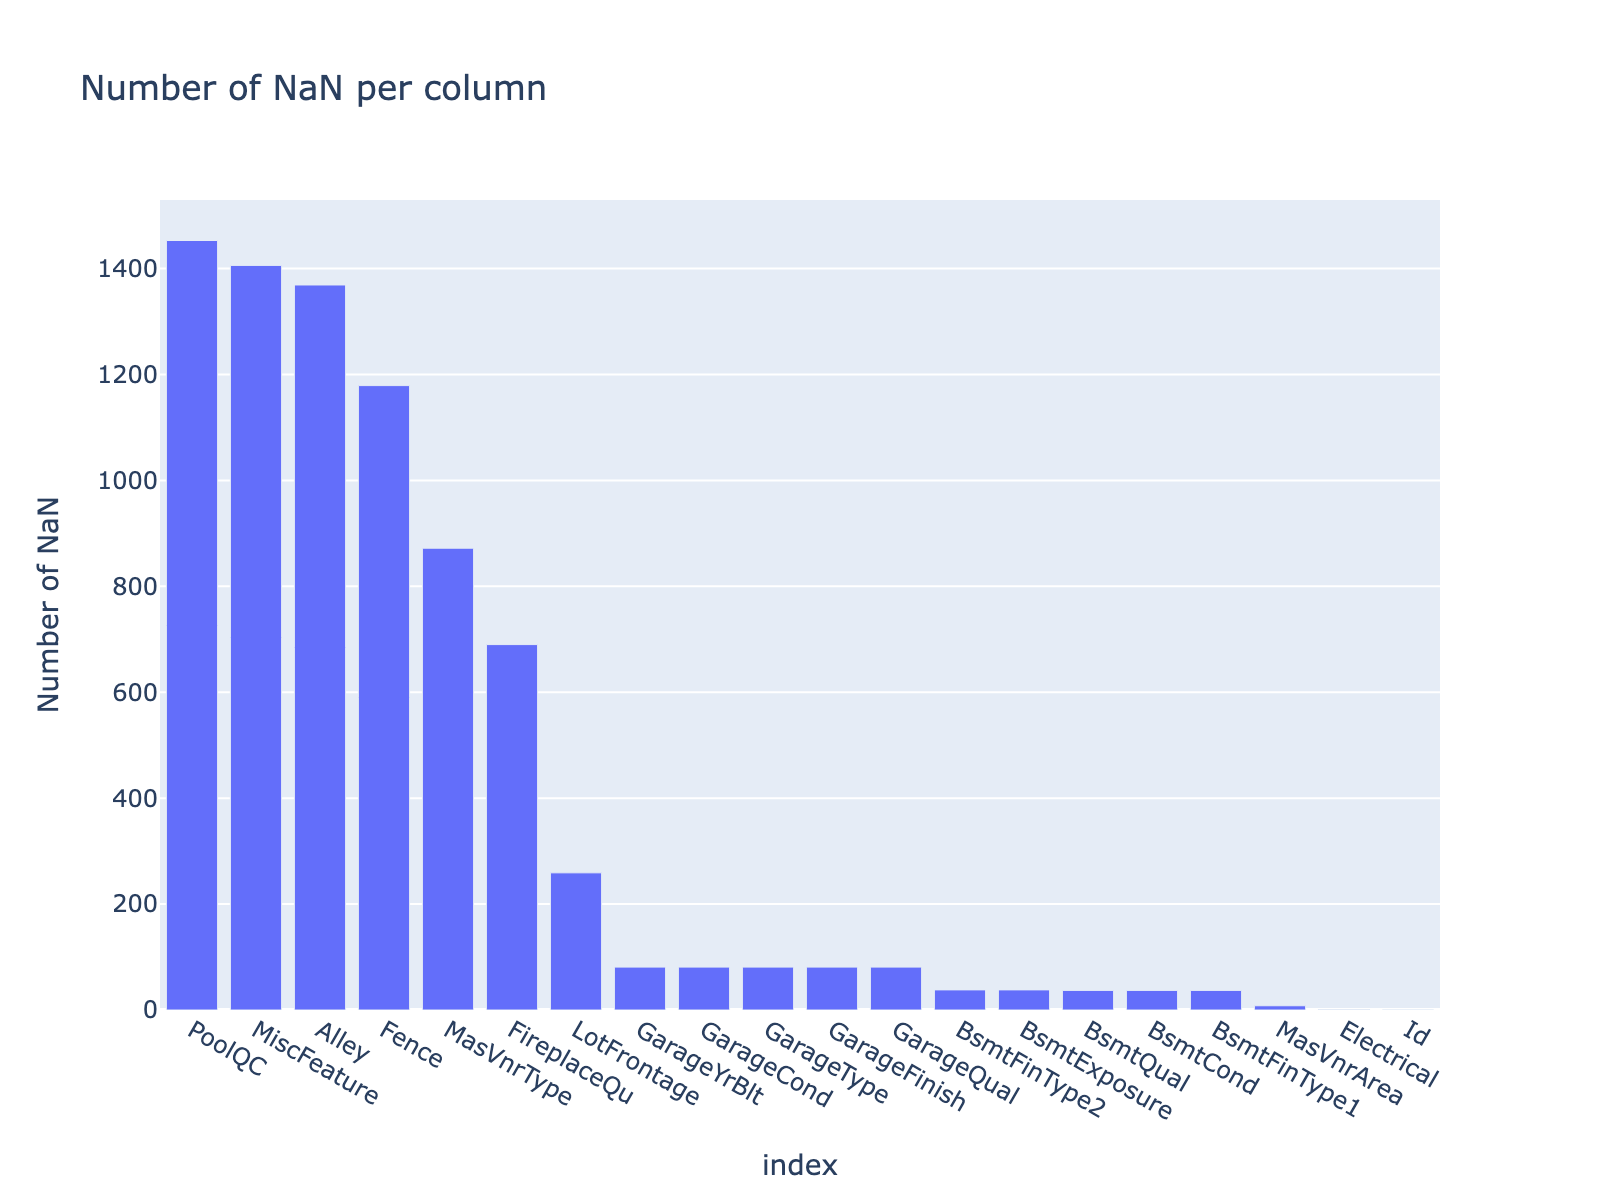

In [31]:
top20 = nans_df.head(20)
fig = px.bar(
    top20, 
    x=top20.index,
    y=top20.values,
    labels={"x": "Columns", "y": "Number of NaN"},
    title="Number of NaN per column"
)
fig.update_layout(width=1000, height=800)
fig.show(renderer="png", width=800, height=600, scale=2)

**We drop these columns and verify that the dataset contains no remaining NaNs:**

In [32]:
X_df = train_df.dropna(axis=1).copy()
print(train_df.isna().sum(), end='\n\n')
print(X_df.isna().sum(), end='\n\n')
print(X_df.head(), end='\n\n')
print(X_df.columns)

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

Id               0
MSSubClass       0
MSZoning         0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 62, dtype: int64

   Id  MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0   1          60       RL     8450   Pave      Reg         Lvl    AllPub   
1   2          20       RL     9600   Pave      Reg         Lvl    AllPub   
2   3          60       RL    11250   Pave      IR1         Lvl    AllPub   
3   4          70       RL     9550   Pave      IR1         Lvl    AllPub   
4   5          60       RL    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope  ... EnclosedPorch 3Ssn

**I selected the most informative columns from the dataset:**

In [33]:
cols = ['GrLivArea', 'OverallQual', 'SalePrice']

X_df = X_df[cols]
X_df.head()

,GrLivArea,OverallQual,SalePrice
0,1710,7,208500
1,1262,6,181500
2,1786,7,223500
3,1717,7,140000
4,2198,8,250000


**Split them and recheck**

In [34]:
FEATURES = ["GrLivArea", "OverallQual"]
TARGET = "SalePrice"
df = (
    X_df[cols]
    .astype(float)
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
).dropna(axis=0, how="any").copy()

**Lets plot them in 3D space**

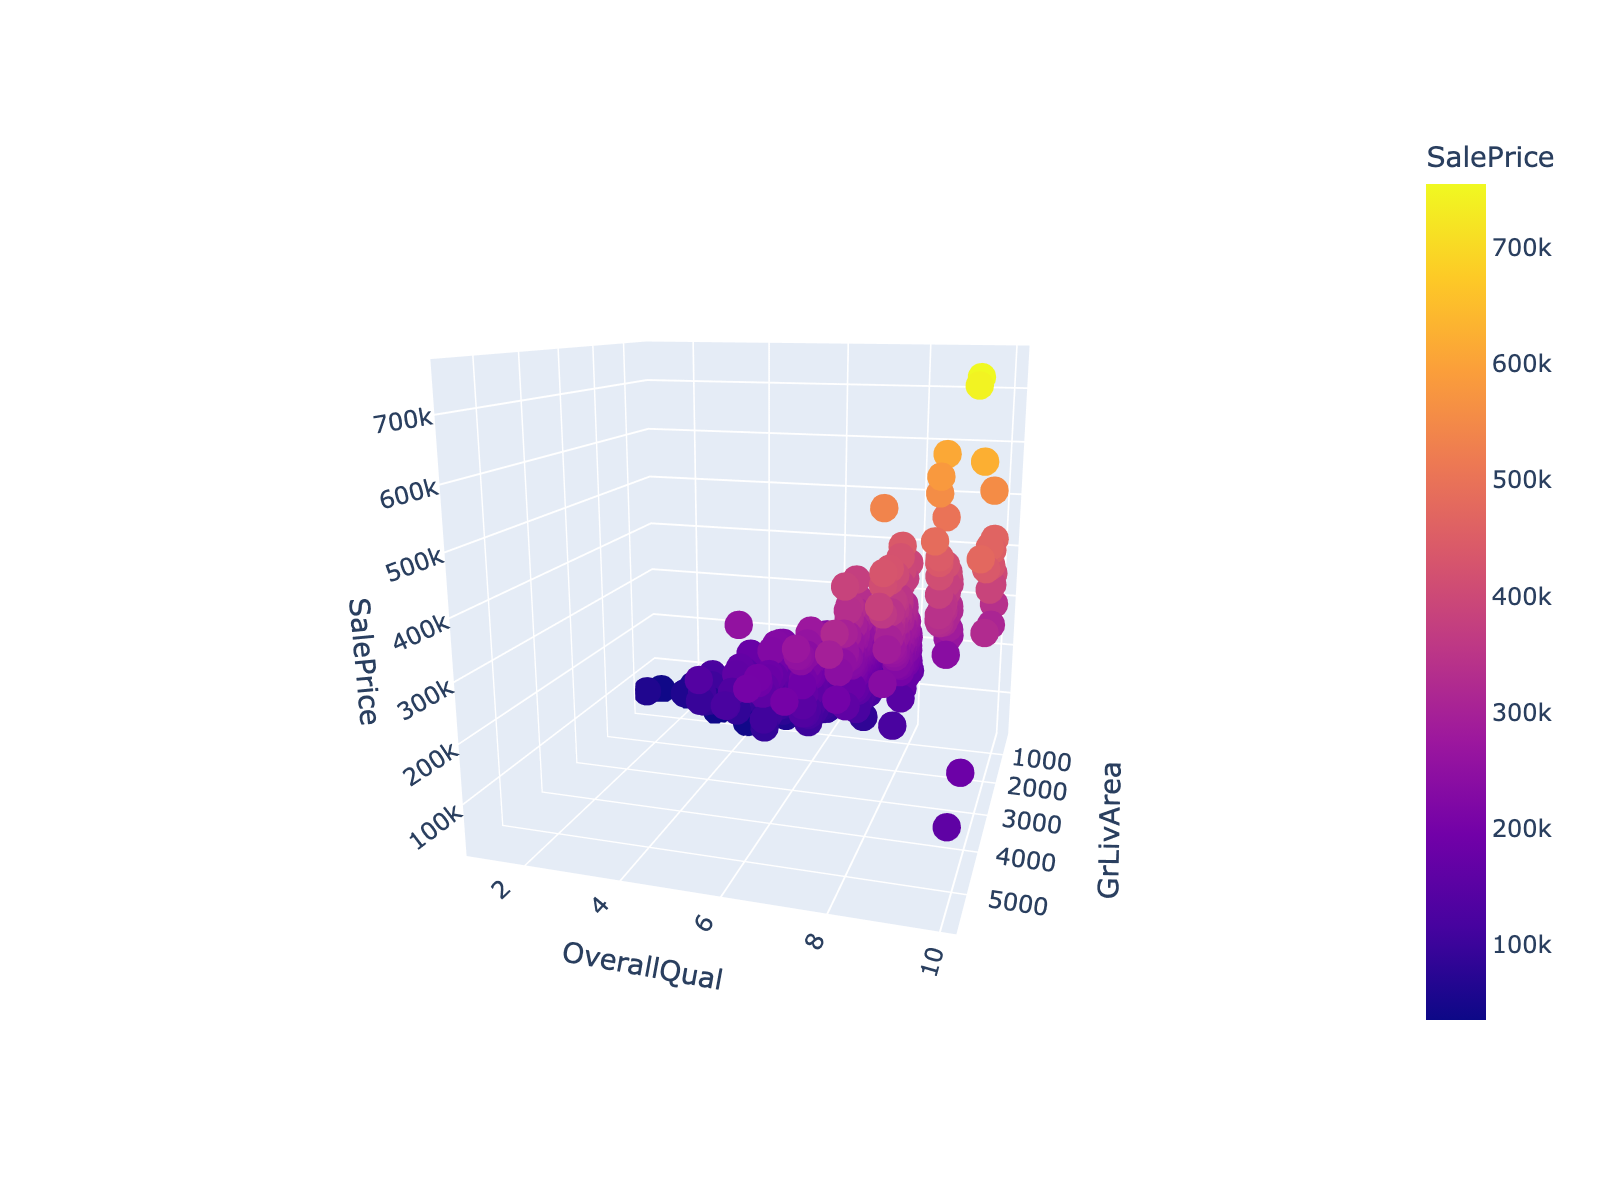

In [55]:
x = df[cols[0]]
y = df[cols[1]]
z = df[cols[2]]
fig = px.scatter_3d(
    df, 
    x=cols[0], 
    y=cols[1], 
    z=cols[2], 
    color=cols[2], 
    size_max=10,
)

fig.update_layout(
    scene_camera=dict(
        eye=dict(x=2.3, y=0.7, z=0.6)
    )
)

fig.show(renderer="png", width=800, height=600, scale=2)

Drawing tools:

In [36]:
import os, io
import imageio.v3 as iio
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display
import matplotlib.gridspec as gridspec

def init_loss_plot(title="Losses (RMSE)", static=False):
    if static:
        fig = go.Figure()
    else:
        fig = go.FigureWidget()
    fig.add_scatter(mode="lines+markers", name="rmse")
    fig.update_layout(title=title, xaxis_title="Epoch", yaxis_title="RMSE")
    return fig


def append_loss(fig, epoch, value, autoshow_static=False):
    x = list(fig.data[0].x or [])
    y = list(fig.data[0].y or [])
    x.append(epoch); y.append(value)

    if isinstance(fig, go.FigureWidget):
        with fig.batch_update():
            fig.data[0].x = x
            fig.data[0].y = y
    else:
        fig.data[0].x = x
        fig.data[0].y = y
        if autoshow_static:
            fig.show(renderer="png")

def finalize_loss_plot(fig, path="assets/loss_curve.png"):
    fig.write_image(path)
    try:
        display(Image(filename=path))
    except Exception:
        pass

def export_gif(
    X_raw: np.ndarray,
    Y: np.ndarray,
    mu,
    sigma,
    W_hist,
    B_hist,
    feature_names=("x", "y"),
    target_name="z",
    path="assets/regression_animation.gif",
    grid_size=64,
    frame_ms=60,
    dpi=160,
    elev=28,            # 3d angle
    azim_start=-60,
    azim_step=2,
    scatter_size=8,
    surface_alpha=0.75,
    levels=18,
    margin=0.05,
) -> None:
    # create direcotry for GIF
    os.makedirs(os.path.dirname(path), exist_ok=True)

    # grid for surface
    x_min, x_max = X_raw[:, 0].min(), X_raw[:, 0].max()
    y_min, y_max = X_raw[:, 1].min(), X_raw[:, 1].max()
    dx = (x_max - x_min) * margin
    dy = (y_max - y_min) * margin

    grid_x = np.linspace(x_min - dx, x_max + dx, grid_size)
    grid_y = np.linspace(y_min - dy, y_max + dy, grid_size)
    Grid_X, Grid_Y = np.meshgrid(grid_x, grid_y)

    grid_raw = np.c_[Grid_X.ravel(), Grid_Y.ravel()]
    grid_std = apply_standard(grid_raw, mu, sigma)

    frames_png = []
    n_frames = len(W_hist)

    x_data = X_raw[:, 0]
    y_data = X_raw[:, 1]
    z_data = Y[:, 0]

    for i in range(n_frames):
        Z_i: np.ndarray = predict(grid_std, W_hist[i], B_hist[i]).reshape(Grid_X.shape)

        # Figure and grid
        fig = plt.figure(figsize=(11, 8.5), dpi=dpi)
        gs = gridspec.GridSpec(2, 2, height_ratios=[3, 2], width_ratios=[3, 2])
        gs.update(wspace=0.18, hspace=0.22)

        # 3D
        ax3d = fig.add_subplot(gs[0, 0], projection="3d")
        ax3d.scatter(x_data, y_data, z_data, s=scatter_size, alpha=0.7, depthshade=True)
        ax3d.plot_surface(Grid_X, Grid_Y, Z_i, alpha=surface_alpha, linewidth=0, antialiased=True)
        ax3d.set_xlabel(feature_names[0])
        ax3d.set_ylabel(feature_names[1])
        ax3d.set_zlabel(target_name)
        ax3d.view_init(elev=elev, azim=azim_start + i * azim_step)
        ax3d.set_title(f"Epoch {i}/{n_frames - 1}")

        # from the top
        ax_xy = fig.add_subplot(gs[0, 1])
        ax_xy.contourf(Grid_X, Grid_Y, Z_i, levels=int(levels))
        ax_xy.scatter(x_data, y_data, s=6, alpha=0.5)
        ax_xy.set_xlabel(feature_names[0])
        ax_xy.set_ylabel(feature_names[1])
        ax_xy.set_title("Top view (XY, contours)")

        # on X/Z and Y/Z
        z_x = Z_i.mean(axis=0)
        z_y = Z_i.mean(axis=1)

        ax_xz = fig.add_subplot(gs[1, 0])
        ax_xz.plot(grid_x, z_x)
        ax_xz.scatter(x_data, z_data, s=6, alpha=0.4)
        ax_xz.set_xlabel(feature_names[0])
        ax_xz.set_ylabel(target_name)
        ax_xz.set_title("Front view (XZ, mean over Y)")

        ax_yz = fig.add_subplot(gs[1, 1])
        ax_yz.plot(grid_y, z_y)
        ax_yz.scatter(y_data, z_data, s=6, alpha=0.4)
        ax_yz.set_xlabel(feature_names[1])
        ax_yz.set_ylabel(target_name)
        ax_yz.set_title("Side view (YZ, mean over X)")

        for ax in (ax_xy, ax_xz, ax_yz):
            ax.grid(True, linewidth=0.6, alpha=0.4)

        # collect frame
        buf = io.BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight", dpi=dpi)
        plt.close(fig)
        buf.seek(0)
        frames_png.append(iio.imread(buf))

    # save to GIF
    iio.imwrite(path, frames_png, duration=frame_ms, loop=0)
    print(f"GIF saved to: {path}")


### Feature Standardization

Before training the model, it is important to **normalize the input features** so that they are on the same scale.  
Otherwise, features with larger numeric ranges would dominate the learning process.

We use the **z-score standardization** formula:

$$
X_{std} = \frac{X - \mu}{\sigma}
$$

- $\mu$ — mean of each feature (column-wise)
- $\sigma$ — standard deviation of each feature
- To avoid division by zero, we replace very small values of $\sigma$ with `1.0`

This ensures that every feature has approximately **zero mean** and **unit variance**.  
Such preprocessing helps gradient descent converge faster and prevents numerical instability.

Look at axis on this illustration:

![Standardization Example](assets/Figure_1.png)


In [37]:
def standardize(X: np.ndarray, eps=1e-8) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, keepdims=True)
    safe_sigma = np.where(sigma < eps, 1.0, sigma)
    X_std = (X - mu) / safe_sigma
    return X_std, mu, safe_sigma

def apply_standard(X_raw: np.ndarray, mu, sigma):
    return (X_raw - mu) / (sigma + 1e-8)

def logger(epoch, rmse_val):
    print(f"epoch {epoch:5d} | RMSE = {rmse_val:.4f} ($)")

## Linear Regression: Model, Loss and Optimization

We consider a dataset with features 
$X \in \mathbb{R}^{n \times d}$ 
and target 
$Y \in \mathbb{R}^{n \times 1}$.

---

### Model
A linear model predicts:

$$
\hat{Y} = XW + b
$$

where  
- $W \in \mathbb{R}^{d \times 1}$ — weight vector,  
- $b \in \mathbb{R}^{1 \times 1}$ — bias term.

---

### Loss Function (MSE)
We optimize the **Mean Squared Error (MSE):**

$$
\mathcal{L}(W, b) \;=\; \frac{1}{n} \sum_{i=1}^{n}\bigl(y_i - \hat{y}_i\bigr)^2
\;=\; \frac{1}{n}\,\lVert Y - \hat{Y}\rVert_2^2
$$

---

### Metric (RMSE)
For reporting, we use the **Root Mean Squared Error (RMSE):**

$$
\mathrm{RMSE}(Y, \hat{Y}) \;=\; 
\sqrt{\frac{1}{n}\,\lVert Y - \hat{Y}\rVert_2^2}
$$

---

### 2D example:

![2D Linear model exmple](assets/Figure_2.png)

In [38]:
def predict(X: np.ndarray, W: np.ndarray, b: np.ndarray) -> np.ndarray:
    return X @ W + b

def mse(Y: np.ndarray, Y_hat: np.ndarray):
    diff = Y - Y_hat
    return float(np.mean(np.power(diff, 2), dtype=np.float64))

def rmse(Y: np.ndarray, Y_hat: np.ndarray):
    return float(np.sqrt(mse(Y, Y_hat)))

## Gradients of the MSE

Let 

$$
E = \hat{Y} - Y = XW + b - Y
$$

Using matrix calculus, the gradients are:

$$
\nabla_W \mathcal{L}(W,b) \;=\; \frac{2}{n}\, X^\top E
\qquad
\nabla_b \mathcal{L}(W,b) \;=\; \frac{2}{n}\, \mathbf{1}^\top E
$$

where  
- $\mathbf{1}$ is an $n \times 1$ vector of ones.  

---

We update $W$ and $b$ **against** the gradient direction to reduce the loss.

Take a look (example):

![Gradient Descent animation](assets/gradient_descent_good.gif)

---

There is too large learning rate example:

![Too large learning rate](assets/gd_too_large.gif)

---

There is too small learning rate example:

![Too small learnning rate](assets/gd_too_small.gif)


In [39]:
def grads(X: np.ndarray, Y: np.ndarray, W: np.ndarray, b: np.ndarray):
    n = X.shape[0]
    E = predict(X, W, b) - Y
    dW = (2.0 / n) * (X.T @ E)
    db = (2.0 / n) * E.sum(axis=0, keepdims=True)
    return dW, db

## Gradient Descent Update

A single update step with learning rate $\eta > 0$ is:

$$
W = W - \eta \,\nabla_W \mathcal{L} 
\qquad
b = b - \eta \,\nabla_b \mathcal{L}
$$

$\eta$ (learning rate or lr) — the key to effective training.

Too big $\eta$:


In [40]:
def step(X: np.ndarray, Y: np.ndarray, W: np.ndarray, b: np.ndarray, lr=1e-3) -> tuple[np.ndarray, np.ndarray]:
    dW, db = grads(X, Y, W, b)
    return W - lr * dW, b - lr * db

## Training Loop

We train for $T$ epochs using **full-batch gradient descent**.  
At each epoch $t = 1, \dots, T$:

1. **Prediction:**
   $$
   \hat{Y}^{(t)} \;=\; X W^{(t-1)} + b^{(t-1)}
   $$

2. **Evaluation (reporting):**
   $$
   \mathrm{RMSE}^{(t)} \;=\; \sqrt{\tfrac{1}{n}\,\lVert Y - \hat{Y}^{(t)} \rVert_2^2}
   $$

3. **Parameter update:**
   $$
   W^{(t)} = W^{(t-1)} - \eta \,\nabla_W \mathcal{L}
   \qquad
   b^{(t)} = b^{(t-1)} - \eta \,\nabla_b \mathcal{L}
   $$

---

⚠️ **Note:**  
Convergence is highly sensitive to  
- the learning rate $\eta$
- and proper feature scaling (standardization)


In [41]:
def train(X_std: np.ndarray, Y: np.ndarray, W0: np.ndarray=None, b0: np.ndarray=None, epochs=10, lr=None,
                       show_every=1, patience=5, tol=1e-8, logger=None):
    W, b = W0.copy(), b0.copy()

    rmse_hist = []
    W_hist, B_hist = [W.copy()], [b.copy()]

    best = np.inf
    stall = 0
    fig = init_loss_plot("Losses (RMSE)", static=True)
    for epoch in range(epochs):
        Y_hat = predict(X_std, W, b)
        loss = rmse(Y, Y_hat)
        rmse_hist.append(loss)
        append_loss(fig, epoch, loss, autoshow_static=False)

        if logger and (epoch+1) % show_every == 0:
            logger(epoch+1, loss)

        if loss + tol < best:
            best = loss; stall = 0
        else:
            stall += 1
            if stall >= patience:
                break

        W, b = step(X_std, Y, W, b, lr=lr)

        W_hist.append(W.copy())
        B_hist.append(b.copy())
    fig.show(renderer="png") 
    finalize_loss_plot(fig, "assets/loss_curve.png")
    return W, b, rmse_hist, W_hist, B_hist

/var/folders/v5/s1xq87zn1dvdrbfxxxpjgm3w0000gn/T/ipykernel_38116/1922130164.py:2: RuntimeWarning:

divide by zero encountered in matmul

/var/folders/v5/s1xq87zn1dvdrbfxxxpjgm3w0000gn/T/ipykernel_38116/1922130164.py:2: RuntimeWarning:

overflow encountered in matmul

/var/folders/v5/s1xq87zn1dvdrbfxxxpjgm3w0000gn/T/ipykernel_38116/1922130164.py:2: RuntimeWarning:

invalid value encountered in matmul



epoch     1 | RMSE = 197567.0052 ($)
epoch     2 | RMSE = 191525.5225 ($)
epoch     3 | RMSE = 185699.7957 ($)
epoch     4 | RMSE = 180081.9684 ($)
epoch     5 | RMSE = 174664.5207 ($)
epoch     6 | RMSE = 169440.2526 ($)
epoch     7 | RMSE = 164402.2692 ($)
epoch     8 | RMSE = 159543.9657 ($)
epoch     9 | RMSE = 154859.0142 ($)
epoch    10 | RMSE = 150341.3495 ($)
epoch    11 | RMSE = 145985.1577 ($)
epoch    12 | RMSE = 141784.8632 ($)
epoch    13 | RMSE = 137735.1177 ($)
epoch    14 | RMSE = 133830.7895 ($)
epoch    15 | RMSE = 130066.9526 ($)
epoch    16 | RMSE = 126438.8771 ($)
epoch    17 | RMSE = 122942.0195 ($)
epoch    18 | RMSE = 119572.0140 ($)
epoch    19 | RMSE = 116324.6634 ($)
epoch    20 | RMSE = 113195.9310 ($)
epoch    21 | RMSE = 110181.9325 ($)
epoch    22 | RMSE = 107278.9290 ($)
epoch    23 | RMSE = 104483.3190 ($)
epoch    24 | RMSE = 101791.6318 ($)
epoch    25 | RMSE = 99200.5211 ($)
epoch    26 | RMSE = 96706.7583 ($)
epoch    27 | RMSE = 94307.2266 ($)
epoc

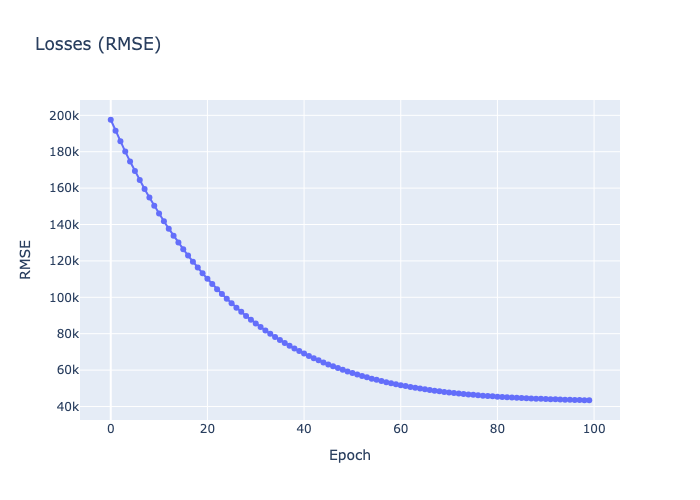

/var/folders/v5/s1xq87zn1dvdrbfxxxpjgm3w0000gn/T/ipykernel_38116/1922130164.py:2: RuntimeWarning:

divide by zero encountered in matmul

/var/folders/v5/s1xq87zn1dvdrbfxxxpjgm3w0000gn/T/ipykernel_38116/1922130164.py:2: RuntimeWarning:

overflow encountered in matmul

/var/folders/v5/s1xq87zn1dvdrbfxxxpjgm3w0000gn/T/ipykernel_38116/1922130164.py:2: RuntimeWarning:

invalid value encountered in matmul

/opt/anaconda3/envs/base_2/lib/python3.12/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/opt/anaconda3/envs/base_2/lib/python3.12/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul



GIF saved to: assets/regression_animation.gif
================ RESULTS ===============
RMSE: 43375.13103971011


In [42]:
# from DataFrame to matrix
X_raw = df[FEATURES].to_numpy(dtype=np.float64)
Y = df[[TARGET]].to_numpy(dtype=np.float64)
X_std, mu, sigma = standardize(X_raw)

n, d = X_std.shape
W0 = np.zeros((d, 1), dtype=np.float64)
b0 = np.array([[Y.mean() * 1e-4]], dtype=np.float64) # 1e-4 here - for GIF, delete for optimization

W_tr, b_tr, rmse_hist, W_hist, B_hist = train(
    X_std, Y, W0, b0,
    epochs=100,
    lr=0.015, # for smoother GIF
    show_every=1,
    patience=200,
    logger=logger
)

export_gif(
    X_raw, Y, mu, sigma, W_hist, B_hist,
    feature_names=(FEATURES[0], FEATURES[1]),
    target_name=TARGET,
    path="assets/regression_animation.gif",
    grid_size=32,
    frame_ms=60,
    dpi=120
)

print("================ RESULTS ===============")
print("RMSE:", rmse(Y, predict(X_std, W_tr, b_tr)))

And we can now visualize the result:  
the regression surface gradually converges towards its **optimal position** between the data points.

![Result](assets/regression_animation.gif)